# Resting EEG Data

This notebook analyzes a dataset of EEG data collected from healthy young adults.

## Dataset Details

This dataset is a dataset of extra-cranial EEG data recorded in the Voytek Lab. 

Analyzed data is taken from eyes-closed resting state data collected prior to a visual-detection psychophysics task.

In [1]:
from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_65514/938709085.py:1: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, load_eeg_demo_data
from apm.run import run_measures, run_group_measures
from apm.analysis import (compute_avgs, compute_all_corrs, compute_corrs_to_feature,
                          compute_diffs_to_feature, unpack_corrs)
from apm.plts import plot_dots
from apm.plts.utils import make_axes
from apm.methods import specparam, irasa, hurst, dfa, hjorth_complexity, lempelziv, app_entropy
from apm.methods.periodic import alpha_power
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Define the data folder
folder = '/Users/tom/Data/VoytekLab/ExtractedSubsets/eeg_data'

In [5]:
# Define data field to extract from files
data_field = 'oz_rest_data'

In [6]:
# Define data information
fs = 500
n_seconds = 120

In [7]:
# Define times vector for data
times = create_times(n_seconds, fs)

In [8]:
# Add plot kwargs
dot_kwargs = {
    'alpha' : 0.75,
}

In [9]:
# Settings for saving figures
SAVE_FIG = False
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '41_eeg_data'

## Load Data


In [10]:
# Get the list of available files
files = get_files(folder, select='.mat')

In [11]:
# FIX: temporarily drop subject which has a data quirk (wrong size array)
files.remove('1009.mat')

In [12]:
# Check the number of subjects
n_subjs = len(files)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 28


In [13]:
# Load data
data = load_eeg_demo_data(files, folder, data_field)

## Data Checks

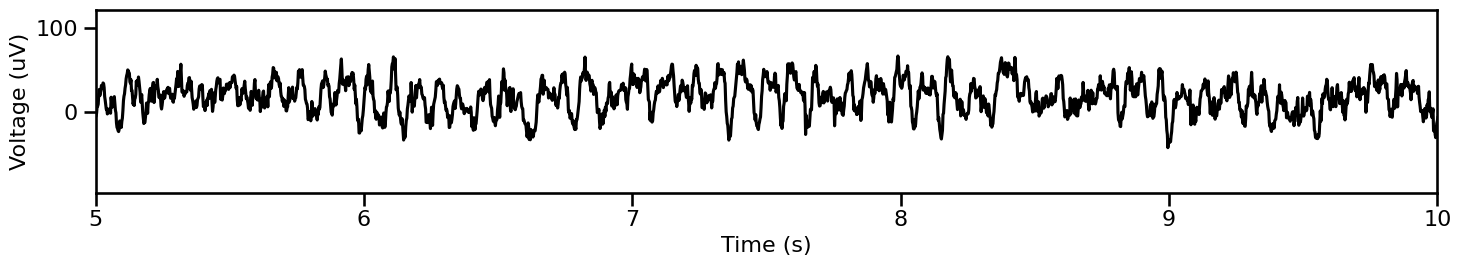

In [14]:
# Plot a segment of time series data
plot_time_series(times, data[0, :], xlim=[5, 10])

In [15]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[0, :], fs, nperseg=2*fs, noverlap=fs)

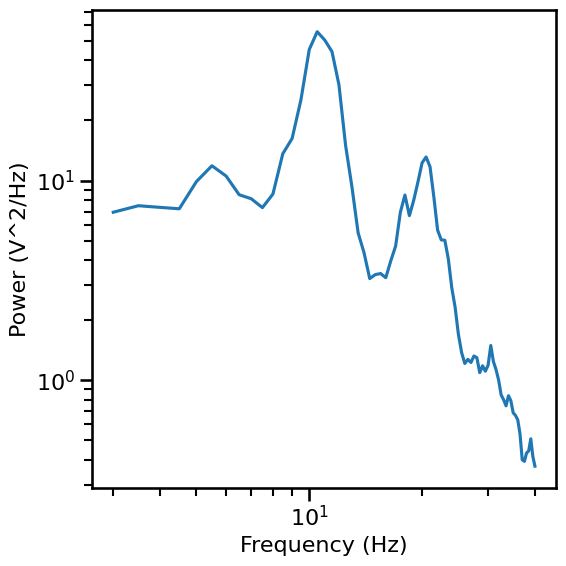

In [16]:
# Plot the power spectrum of the example data segment
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]))

## Compare Methods

In [17]:
# General method settings
f_range = [3, 40]

In [18]:
# # Initialize specparam model
# fm = FOOOF(verbose=False)

In [19]:
# Define measures to apply, along with input parameters
measures = {
    specparam : {'fs' : fs, 'f_range' : f_range},
    irasa : {'fs' : fs, 'f_range' : f_range},
    hurst : {'fs' : fs},
    dfa : {'fs' : fs},
    lempelziv : {},
    hjorth_complexity : {},
    app_entropy : {}
}

In [20]:
# # Compute measures of interest on the data
# results = run_measures(data, measures)

In [21]:
# # Compute correlations across all pairs of methods
# all_corrs = compute_all_corrs(results)

#### Compare Exponent Measures

In [22]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs,
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='eeg_exp_exp_comp' + EXT, file_path=FIGPATH)

NameError: name 'results' is not defined

In [ ]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

#### Compare exponent to LZ Complexity

In [ ]:
# Plot the comparison of specparam and lempel-ziv complexity
plot_dots(results['specparam'], results['lempelziv'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity',
          save_fig=SAVE_FIG, file_name='eeg_exp_lz_comp' + EXT, file_path=FIGPATH)

In [ ]:
# Check the correlation
print('  SP-EXP & LZC:  ', format_corr(*all_corrs['specparam']['lempelziv']))
print('  IR-EXP & LZC:  ', format_corr(*all_corrs['irasa']['lempelziv']))

#### Compare exponent to entropy

In [ ]:
# Plot the comparison of specparam and approximate entropy
plot_dots(results['specparam'], results['app_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Entropy',
          save_fig=SAVE_FIG, file_name='eeg_exp_ent_comp' + EXT, file_path=FIGPATH)

In [ ]:
# Check the correlation between approximate entropy and exponent measures
print('  SP-EXP & ENT:  ', format_corr(*all_corrs['specparam']['app_entropy']))
print('  IR-EXP & ENT:  ', format_corr(*all_corrs['irasa']['app_entropy']))

## Compare to Alpha Power

### Compute Alpha Power

In [37]:
# Define periodic measures to compute
peak_measures = {alpha_power : measures[specparam]}

In [38]:
# Compute periodic measures
peak_results = run_measures(data, peak_measures)

In [70]:
# Compute correlations between aperiodic measures and alpha power
alpha_corrs = compute_corrs_to_feature(results, peak_results['alpha_power'])

NameError: name 'results' is not defined

In [ ]:
# Compute differences between correlations between aperiodic measures and alpha power
alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [ ]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

## Topographies

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns

import mne
from mne.viz import plot_topomap

In [23]:
path = Path('/Users/tom/Desktop/apm_data/')

In [24]:
data1 = np.load(path / 'rtPB_extracted_block.npy')
data2 = np.load(path / 'PBA_extracted_block.npy')
group_data = np.vstack([data1, data2])

In [25]:
FS = 500

In [26]:
with open(path / 'ch_names.txt') as file:
    ch_names = [str(line.strip()) for line in file]

In [27]:
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names, FS, 'eeg')
info = info.set_montage(montage)

In [28]:
group_results = run_group_measures(group_data, measures)

In [29]:
group_avg = compute_avgs(group_results)

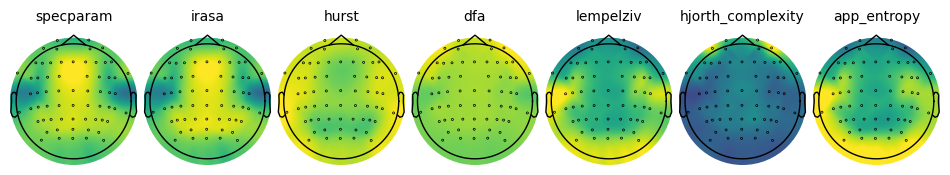

In [30]:
axes = make_axes(1, 7, figsize=(12, 3), wspace=0.05)
for measure, ax in zip(group_avg, axes):
    ax.set_title(measure, fontdict={'fontsize' : 10})
    plot_topomap(group_avg[measure], info, cmap=cm.viridis, contours=0, size=2, axes=ax, show=False)

In [31]:
group_corrs = compute_all_corrs(group_avg)

In [32]:
group_corrs_mat = unpack_corrs(group_corrs)

In [34]:
mask = np.triu(group_corrs_mat)
labels = list(group_corrs.keys())

<Axes: >

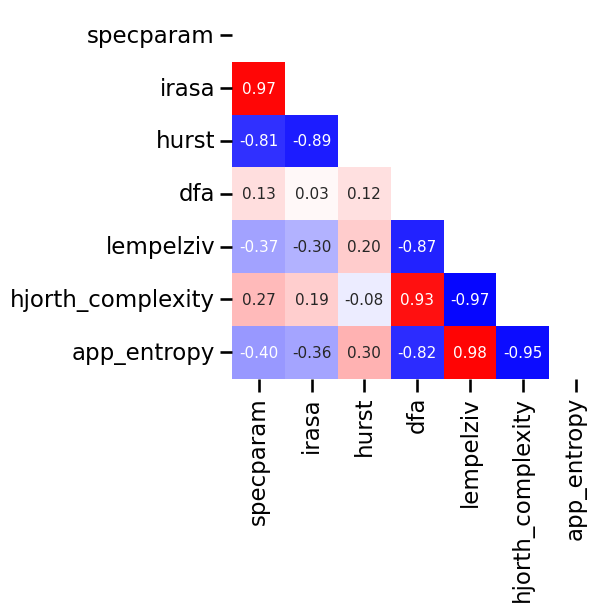

In [35]:
sns.heatmap(group_corrs_mat, cmap="bwr", annot=True, fmt='1.2f', cbar=False, square=True,
            vmin=-1, vmax=1, annot_kws={"size": 11}, mask=mask,
            xticklabels=labels, yticklabels=labels)#, ax=ax1);

In [41]:
group_results_peaks = run_group_measures(group_data, peak_measures)

In [54]:
group_results_peaks['alpha_power'] = np.log10(group_results_peaks['alpha_power'])

In [55]:
group_avg_peaks = compute_avgs(group_results_peaks)

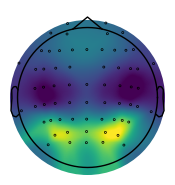

(<matplotlib.image.AxesImage at 0x7fc376c91a30>, None)

In [64]:
plot_topomap(group_avg_peaks['alpha_power'], info, cmap=cm.viridis,
             contours=0, size=2, vlim=(-11.5, -10.5))

In [67]:
# Compute correlations between aperiodic measures and alpha power
group_alpha_corrs = compute_corrs_to_feature(group_avg, group_avg_peaks['alpha_power'])

In [69]:
# Compute differences between correlations between aperiodic measures and alpha power
group_alpha_corr_diffs = compute_diffs_to_feature(group_avg, group_avg_peaks['alpha_power'])

## Conclusions

Conclusions of this empirical data analysis thus far:
- in this EEG data, the specparam & IRASA exponent estimates are highly comparable
- in this empirical data, aperiodic exponent is moderately correlated with the time domain methods

Note that this dataset is analyzed as a small / pilot, such that these interim conclusions are not considered decisive, and are best considered as initial results to be further explored and replicated in subsequent larger datasets.